# Classification Loss Functions and Metrics

In [2]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a dark background
sns.set_style("whitegrid")

## Cross-entropy (aka logistic Loss, log-loss, or softmax loss)

Assume that we have a probabilistic classifier with parameters $\theta$.  

For each $\theta$, the classifier takes a feature vector $x$ as input and returns the vector $P_\theta( y | x) = [P(y = 1 | x), P(y = 2 | x), \dots P(y = C | x)]$ as output.  For instance in a 3 class problem we might get the output $[0.2, 0.7, 0.1]$ to indicate the probability of each of the three classes. In sklearn this will be the output of the `.predict_proba` method applied to a single row matrix.

To match this convention, let's also output the actual class in the same format:  $[0,0,1]$ for example.  If you had originally had other some other convention (for example outputting the index $2$, or a name like 'iris-virginica'), the `pd.get_dummies` method will convert to the format we are talking about here.

If we have $n$ independent observations $(x_i, y_i)$, then the likelihood function is

$$
L(\theta) = \prod_{i=1}^n y_i \cdot P_\theta( y | \vec{x}_i)
$$

Note that if our classifier is predicting a literal $0$ for a class probability, and a training example actual has that class, then we get a $0$ likelihood.  To avoid this, most probabilistic classifiers are constructed in such a way that $0$ probabilities are impossible to output. For instance, in logistic regression the sigmoid function has range $(0,1)$, so a class probability of $0$ or $1$ is never returned.

Instead of maximizing the likelihood, we can minimize the negative log likelihood:

$$
\operatorname{NLL}(\theta) = -\sum_{i=1}^n \log( y_i \cdot P_\theta( y | \vec{x}_i))
$$

This is a little easier to vectorize if we rewrite it as 

$$
\operatorname{NLL}(\theta) = -\sum_{i=1}^n y_i \cdot \log( P_\theta( y | \vec{x}_i))
$$

where we are taking the logarithm of each component of $P_\theta( y | \vec{x}_i)$.  This is okay since none of these components are $0$, and since only one term ultimately contributes to the sum.

**This is the "cross entropy" of the classifier.**

Let's give one hand computable example.

<center>

| Actual Class | Predicted Probs |
|--------------|-----------------|
| $[1,0,0]$    | $[0.8,0.1,0.1]$ |
| $[0,0,1]$    | $[0.1,0.3,0.6]$ |
| $[0,1,0]$    | $[0.09,0.01,0.9]$ |

</center>

$$
\begin{align*}
\operatorname{CrossEntropy} 
&= - (\log(0.8) + \log(0.6) + \log(0.01))\\
&= - (-0.22 + -0.51 + -4.60)\\
&= 0.22 + 0.51 + 4.60\\
&= 5.34
\end{align*}
$$

Notice that cross-entropy "rewards" the classifier with when it is confidently correct (like the first observation), and "punishes" the classifier when it is confidently incorrect (like the last example).

Terry Tao proposes using cross-entropy as a way to score multiple choice examinations where the student is allowed to give a probability for each choice in [this blog post](https://terrytao.wordpress.com/2016/06/01/how-to-assign-partial-credit-on-an-exam-of-true-false-questions/comment-page-1/).  The derivation of cross entropy provided there might give you some additional intuition.  

Side Note:  I do not advocate implementing this grading strategy in real life!

Cross entropy is also called "logistic loss" since it is the loss function used for logistic regression.  However, since it is also used for many other classification algorithms, calling it "logistic loss" (or "log-loss") is perhaps a bit anachronistic.

## The Confusion Matrix

Whether we are interested in a couple of classes or all of the classes we can still gather useful information from the confusion matrix. 

<img src="lecture_assets/conf_mat_multi.png" width="70%"></img>

Let's see this in action in `sklearn`.

In [3]:
from sklearn.datasets import load_iris

In [4]:
iris = load_iris(as_frame=True)

X = iris['data']
X = X.rename(columns={'sepal length (cm)':'sepal_length',
                         'sepal width (cm)':'sepal_width',
                         'petal length (cm)':'petal_length',
                         'petal width (cm)':'petal_width'})
y = iris['target']

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y,
                                                       shuffle=True,
                                                       random_state=413,
                                                       test_size=.2,
                                                       stratify=y)

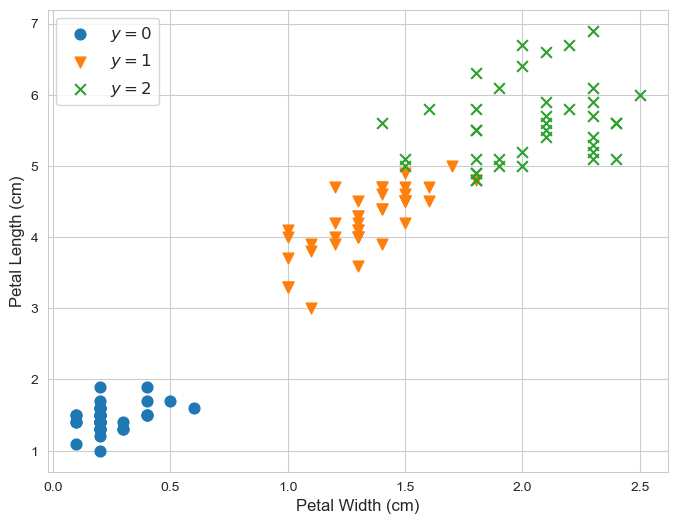

In [7]:
plt.figure(figsize=(8,6))

plt.scatter(X_train.loc[y_train==0].petal_width, 
                X_train.loc[y_train==0].petal_length,
                s = 60,
                label='$y=0$')
plt.scatter(X_train.loc[y_train==1].petal_width, 
                X_train.loc[y_train==1].petal_length,
                marker = 'v',
                s = 60,
                label='$y=1$')
plt.scatter(X_train.loc[y_train==2].petal_width, 
                X_train.loc[y_train==2].petal_length,
                marker = 'x',
                s = 60,
                label='$y=2$')

plt.xlabel("Petal Width (cm)", fontsize=12)
plt.ylabel("Petal Length (cm)", fontsize=12)
plt.legend(fontsize=12)

plt.show()

In [8]:
## import LDA
from sklearn.linear_model import LogisticRegression

In [9]:
## Make LDA object
model = LogisticRegression()

## Fit the model
model.fit(X_train[['petal_width', 'petal_length']], y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [10]:
## import confusion matrix
from sklearn.metrics import confusion_matrix

In [11]:
preds = model.predict(X_test[['petal_width', 'petal_length']])
conf_mat = confusion_matrix(y_test, preds)

In [12]:
pd.DataFrame(conf_mat,
                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2'],
                 index = ['Actual 0', 'Actual 1', 'Actual 2'])

,Predicted 0,Predicted 1,Predicted 2
Actual 0,10,0,0
Actual 1,0,9,1
Actual 2,0,1,9


In [13]:
ycs = 1*pd.get_dummies(y_train).to_numpy()
pcs = model.predict_proba(X_train[['petal_width', 'petal_length']])
loss = - np.sum(ycs * np.log(pcs))
print(f"The cross entropy of this LDA classifier is{loss: .2f}")

The cross entropy of this LDA classifier is 15.81


In [21]:
from sklearn.metrics import log_loss
print(np.round(log_loss(ycs, pcs, normalize=False), 2))

15.81


## Binary Classifier Metrics

### Problems with accuracy

$$
\text{Accuracy } = \ \frac{\text{The number of correct predictions}}{\text{Total number of predictions made}}.
$$

This can be a misleading metric because it obfuscates which kinds of observations the model got correct. For example, if we had a problem where the distribution of classes was: $10\% - 1$ and $90\% - 0$ then a model that predicts every observation to be $0$ would have $90\%$ accuracy. While we would generally assume that $90\%$ indicates good performance, in this situation we have failed to identify any observation that was of class $1$. This would be terrible if, for instance, class $1$ represented the diagnosis of a treatable or curable disease.

We will thus look to develop additional performance metrics for classification problems that will allow us to think about how our models are correct.

### Binary Confusion Matrix

In the two class case the confusion matrix looks like this:

<img src="lecture_assets/conf_mat.png" alt="Confusion Matrix Image" width="50%;">

| Metric | Formula | Approximated Probability | Example Applications |
|--------|:-------:|------------------------|---------------------|
| Accuracy | $\dfrac{\mathrm{TP} + \mathrm{TN}}{\mathrm{TP} + \mathrm{TN} + \mathrm{FP} + \mathrm{FN}}$ | $\operatorname{P}(y = \hat{y})$ | Quality control, digit recognition |
| Total Error Rate (TER) |$ \dfrac{\mathrm{FP} + \mathrm{FN}}{\mathrm{TP} + \mathrm{TN} + \mathrm{FP} + \mathrm{FN}}$ | $\operatorname{P}(y \neq \hat{y})$ | 〃 |
| Recall / Sensitivity / TPR | $\dfrac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}}$ | $\operatorname{P}(\hat{y} = 1 \mid y = 1)$ | Medical diagnosis (cancer screening), fraud detection |
| False Negative Rate (FNR) | $\dfrac{\mathrm{FN}}{\mathrm{TP} + \mathrm{FN}}$ | $\operatorname{P}(\hat{y} = 0 \mid y = 1)$ | 〃 |
| False Positive Rate (FPR) | $\dfrac{\mathrm{FP}}{\mathrm{TN} + \mathrm{FP}}$ | $\operatorname{P}(\hat{y} = 1 \mid y = 0)$ | Intrusion detection systems |
| Specificity / TNR | $\dfrac{\mathrm{TN}}{\mathrm{TN} + \mathrm{FP}}$ | $\operatorname{P}(\hat{y} = 0 \mid y = 0)$ | 〃 |
| Precision / Positive Predictive Value (PPV) | $\dfrac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}}$ | $\operatorname{P}(y = 1 \mid \hat{y} = 1)$ | Legal document search, recommendation systems |
| False Discovery Rate (FDR) | $\dfrac{\mathrm{FP}}{\mathrm{TP} + \mathrm{FP}}$ | $\operatorname{P}(y = 0 \mid \hat{y} = 1)$ | 〃 |
| False Omission Rate (FOR) | $\dfrac{\mathrm{FN}}{\mathrm{FN} + \mathrm{TN}}$ | $\operatorname{P}(y = 1 \mid \hat{y} = 0)$ | Disease testing, safety systems |
| Negative Predictive Value (NPV) | $\dfrac{\mathrm{TN}}{\mathrm{FN} + \mathrm{TN}}$ | $\operatorname{P}(y = 0 \mid \hat{y} = 0)$ | 〃 |
| $\textrm{F}_1$-score | $\dfrac{2 \cdot \mathrm{Precision} \cdot \mathrm{Recall}}{\mathrm{Precision} + \mathrm{Recall}}$ |  | Information retrieval, NLP classification |
| $\textrm{F}_\beta$-score | $\dfrac{(1 + \beta^2) \cdot \mathrm{Precision} \cdot \mathrm{Recall}}{(\beta^2 \cdot \mathrm{Precision}) + \mathrm{Recall}}$ |  | Medical testing (favor recall, $\beta \gg 1$), search engines (favor precision, $\beta \ll 1$) |

Not all of these are implemented as `sklearn` metrics, but they are all easy enough to define from the confusion matrix.

See

https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

for a comprehensive list of the metrics which `sklearn` does have built in functions for.

##  A note on scoring rules and calibration

Cross-entropy is an example of a [strictly proper scoring rule](https://en.wikipedia.org/wiki/Scoring_rule).  That means that the expected value of the score assigned to a distribution is minimized by the true distribution.

A probabilistic model which has been trained by minimizing a strictly proper scoring rule is likely to be **well calibrated**:  the predicted probabilities should line up with the observed frequencies.  Since logistic regression uses cross entropy loss it tends to be well calibrated.

The 538 post ["Checking our work"](https://projects.fivethirtyeight.com/checking-our-work/) looks at how well calibrated 538s predictions are.  It is a great piece for getting some intuitive understanding of why calibration is important!

We do not have time to cover calibration thoroughly in the lecture portion of this course, but I encourage you to read

https://scikit-learn.org/stable/modules/calibration.html

For some applications calibrating your model is **critical**.  For example, say that you are pricing insurance policies.  You don't only care about confusion matrix derived metrics: you really care that your predicted probabilities that people will default on their loans are accurate.  Quantifying this risk of defaulting accurately will be an essential step in determining what rate to offer the customer. 